# Surface tension calculations using DFT for fluids experiencing quantum effects 
Classical density functional theory for interfacial properties of hydrogen, helium, deuterium, neon and their mixtures ([doi:10.1063/5.0137226](https://doi.org/10.1063/5.0137226))

In [1]:
from feos import *
from feos.dft import *
from feos.saftvrqmie import *
import matplotlib.pyplot as plt
import si_units as si
import numpy as np
import seaborn as sns
import json

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')

# Pure fluid surface tension correlations

In [2]:
def surftens_mulero2012(fluid, tr):
    """
    Calculate pure fluid surface tension using Mulero 2012 correlation (doi:10.1063/1.4768782)
    Args:
        fluid (str): Component name
        tr (np.ndarray): Reduced temperature
    Returns:
        sigma (np.ndarray): Surface tension (mN/m)
    """
    ff = open("mulero_2012_parameters.json", "r")
    complist = json.load(ff)
    ff.close()
    sigma = np.zeros_like(tr)
    for i in range(len(complist[fluid]["sigma"])):
        sigma[:] += complist[fluid]["sigma"][i] * \
            (1-tr[:])**complist[fluid]["n"][i]
    return sigma * si.NEWTON / si.METER / (si.MILLI * si.NEWTON/  si.METER)    

In [3]:
def surftens(param, tr):
    """
    Calculate pure fluid surface tension A(1-tr)**(B+C*tr+D*tr**2)
    Args:
        param (np.ndarray): 
        tr (np.ndarray): Reduced temperature
    Returns:
        sigma (np.ndarray): Surface tension (mN/m)
    """
    A = param[0]
    exponent = np.zeros_like(tr)
    exponent[:] = param[1]
    for i in range(2,len(param)):
        exponent += param[i]*tr**(i-1)
    sigma = A*(1-tr)**exponent
    return sigma * si.NEWTON / si.METER / (si.MILLI * si.NEWTON/  si.METER)

# Pure fluid parameters

In [4]:
fluid_param = {}
fluid_param["hydrogen"] = {"Tc": 33.145, "Tnb": 20.369, "xlim": [19.5, 34.0], "ylim": [-0.1, 2.2], "param": None} #Alternative correlation from Hammer et al. (2023): [0.00480413, 0.67152591, 0.47781899]
fluid_param["para-hydrogen"] = {"Tc": 32.938, "Tnb": 20.271, "xlim": [19.5, 34.0], "ylim": [-0.1, 2.2], "param": [0.00471037, 0.62668507, 0.51110266]} #Correlation parameters from Hammer et al. (2023)
fluid_param["neon"] = {"Tc": 44.49, "Tnb": 27.1, "xlim": [26.0, 46.0], "ylim": [-0.1, 5.5], "param": None}
fluid_param["deuterium"] = {"Tc": 38.34, "Tnb": 23.661, "xlim": [22.5, 39.5], "ylim": [-0.1, 3.1], "param": None}

# Select fluid and set up functional

In [5]:
substances = ["hydrogen", "para-hydrogen", "neon", "deuterium"]
substance = substances[0] # Setting fluid
print(f"Calculating surface tension for \033[1m{substance}")

Calculating surface tension for hydrogen


# Set up functional

In [6]:
parameters = SaftVRQMieParameters.from_json([substance], "../../parameters/saftvrqmie/hammer2023.json")
func = HelmholtzEnergyFunctional.saftvrqmie(parameters)
Tc = fluid_param[substance]["Tc"]
Tnb = fluid_param[substance]["Tnb"]
state = State(func, temperature=Tnb * si.KELVIN, pressure=20.0 * si.BAR)
model_tc = State.critical_point(func).temperature

# Calculate and plot surface tension

In [7]:
dia = PhaseDiagram.pure(func, Tnb * si.KELVIN, npoints=50)
sft_dia = SurfaceTensionDiagram(dia.states, n_grid=1024, l_grid=200 * si.ANGSTROM , critical_temperature=model_tc)
surf_tens = sft_dia.surface_tension / (si.MILLI* si.NEWTON / si.METER)

In [8]:
tr = np.linspace(Tnb/Tc, 1.0, 100)
if fluid_param[substance]["param"] is None:
    s_corr = surftens_mulero2012(substance, tr)
    corr_label = "Mulero et al. (2012)"
else:
    s_corr = surftens(fluid_param[substance]["param"], tr)
    corr_label = "Hammer et al. (2023)"

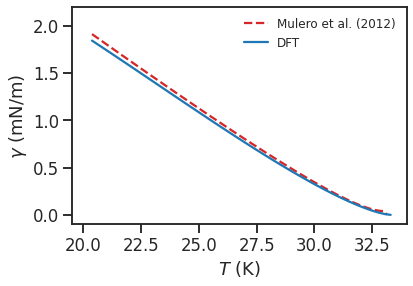

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(tr * Tc, s_corr, color='tab:red', label=corr_label, ls="--")
ax.plot(dia.liquid.temperature/si.KELVIN, surf_tens, color='tab:blue', label='DFT')
xlim = fluid_param[substance]["xlim"]
ylim = fluid_param[substance]["ylim"]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r'$T$ (K)')
ax.set_ylabel(r'$\gamma$ (mN/m)')
legend = ax.legend(loc='best', frameon=False, fontsize=12, ncol=1)

# Calculate mean absolute deviation (MAD)

In [10]:
tr_mad = dia.liquid.temperature / Tc / si.KELVIN
tr_filer_mad = np.less_equal(tr_mad, 0.95)
trx_mad = tr_mad[tr_filer_mad]
if fluid_param[substance]["param"] is None:
    s_corr_mad = surftens_mulero2012(substance, trx_mad)
else:
    print("Correlation")
    s_corr_mad = surftens(fluid_param[substance]["param"], trx_mad)
mad = 100*np.sum(np.abs((surf_tens[tr_filer_mad]-s_corr_mad)/s_corr_mad))/s_corr_mad.shape[0]
print(f"MAD={mad:.1f} %")

MAD=4.4 %
